# Imports

In [19]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import time
import seaborn as sns
import png
import subprocess
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [20]:
pd.set_option("max_colwidth", 100)

In [21]:
ORIG_ADENO_PATH = "/Storage/PauloOctavioDir/nodule_rois/gan/adeno/images/"
ORIG_SQUAMOUS_PATH = "/Storage/PauloOctavioDir/nodule_rois/gan/squamous/images/"
GAN_PATH = "/Storage/PauloOctavioDir/splitted_folders/VGG-GAN/train/images/"

MIN_HU_VALUE = -1024
MAX_HU_VALUE = 1000

In [22]:
%run utils.ipynb

## Visual Inspection

## Statistcal Analysis

In [23]:
def get_windowed_hu(file):
    dicom_data = dcmread(file)
    image = dicom_data.pixel_array
    # Conversio to HU
    intercept = int(dicom_data.RescaleIntercept)
    slope = int(dicom_data.RescaleSlope)
    image = (slope * image) + intercept
    return image

In [64]:
orig_adeno_images = np.concatenate(
    [get_windowed_hu(ADENO_PATH + file).flatten() for file in os.listdir(ADENO_PATH)]
)
orig_squamous_images = np.concatenate(
    [
        get_windowed_hu(SQUAMOUS_PATH + file).flatten()
        for file in os.listdir(SQUAMOUS_PATH)
    ]
)
gan_adeno_images = np.concatenate(
    [
        get_windowed_hu(GAN_PATH + file).flatten()
        for file in os.listdir(GAN_PATH)
        if file.startswith("GAN_LUAD")
    ]
)
gan_squamous_images = np.concatenate(
    [
        get_windowed_hu(GAN_PATH + file).flatten()
        for file in os.listdir(GAN_PATH)
        if file.startswith("GAN_LUSC")
    ]
)

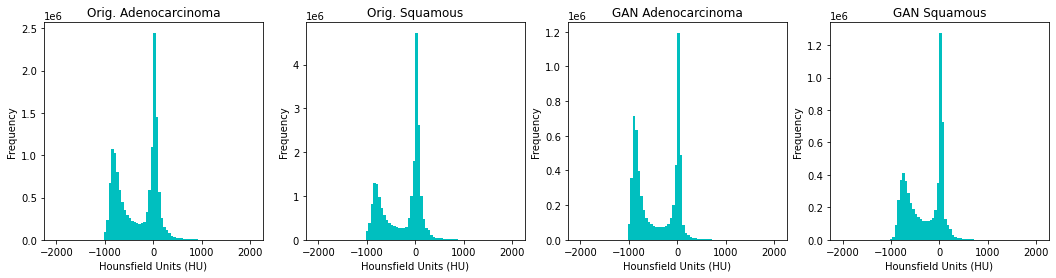

In [68]:
images = [
    orig_adeno_images,
    orig_squamous_images,
    gan_adeno_images,
    gan_squamous_images,
]
titles = [
    "Orig. Adenocarcinoma",
    "Orig. Squamous",
    "GAN Adenocarcinoma",
    "GAN Squamous",
]
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
for i, (data, title) in enumerate(zip(images, titles)):
    axes[i].hist(data, bins=80, color="c", range=(-2048, 2048))
    axes[i].set_xlabel("Hounsfield Units (HU)")
    axes[i].set_ylabel("Frequency")
    axes[i].set_title(title)
plt.show()

## Dimensionality Reduction

In [87]:
images = []
labels = []
NO_IMAGES = 500

In [88]:
for path in [ORIG_SQUAMOUS_PATH, ORIG_ADENO_PATH]:
    for file in os.listdir(path)[:NO_IMAGES]:
        image = get_windowed_hu(path + file)
        image = image.astype(np.uint16)
        image = normalize(image)
        image = cv2.resize(image, (64, 64))
        hist_type = file.split("_")[1]
        label = f"ORIG_{hist_type}"
        images.append(image.flatten())
        labels.append(label)

In [89]:
path = GAN_PATH
for type in ["GAN_LUSC", "GAN_LUAD"]:
    cnt = 0
    for file in os.listdir(path):
        if file.startswith(type) and cnt < NO_IMAGES:
            image = get_windowed_hu(path + file)
            image = image.astype(np.uint16)
            image = normalize(image)
            hist_type = file.split("_")[1]
            label = f"GAN_{hist_type}"
            images.append(image.flatten())
            labels.append(label)
            cnt += 1

In [90]:
X = np.stack(images)
y = np.stack(labels)
print(X.shape, y.shape)

(2000, 4096) (2000,)


In [91]:
feat_cols = ["pixel" + str(i) for i in range(X.shape[1])]

df = pd.DataFrame(X, columns=feat_cols)
df["y"] = y
df["label"] = df["y"].apply(lambda i: str(i))

X, y = None, None

print(df.head(3))
print("Size of the dataframe: {}".format(df.shape))

     pixel0    pixel1    pixel2    pixel3    pixel4    pixel5    pixel6  \
0  0.519290  0.527091  0.538495  0.531175  0.512431  0.545043  0.532580   
1  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2  0.578958  0.588085  0.588388  0.570201  0.537621  0.527191  0.533598   

     pixel7    pixel8    pixel9  ...  pixel4088  pixel4089  pixel4090  \
0  0.510717  0.523466  0.763566  ...   0.522228   0.543468   0.538499   
1  1.000000  1.000000  1.000000  ...   0.977630   0.564820   0.521651   
2  0.540528  0.550403  0.570083  ...   1.000000   1.000000   1.000000   

   pixel4091  pixel4092  pixel4093  pixel4094  pixel4095          y      label  
0   0.518686   0.953917   0.813517   0.531040   0.514048  ORIG_LUSC  ORIG_LUSC  
1   0.550479   0.550408   0.553447   0.989537   1.000000  ORIG_LUSC  ORIG_LUSC  
2   1.000000   1.000000   1.000000   1.000000   1.000000  ORIG_LUSC  ORIG_LUSC  

[3 rows x 4098 columns]
Size of the dataframe: (2000, 4098)


In [92]:
# For reproducability of the results
np.random.seed(42)

rndperm = np.random.permutation(df.shape[0])

### PCA

In [93]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)

df["pca-one"] = pca_result[:, 0]
df["pca-two"] = pca_result[:, 1]
df["pca-three"] = pca_result[:, 2]

print(
    "Explained variation per principal component: {}".format(
        pca.explained_variance_ratio_
    )
)

Explained variation per principal component: [0.20223828 0.09826847 0.07809963]


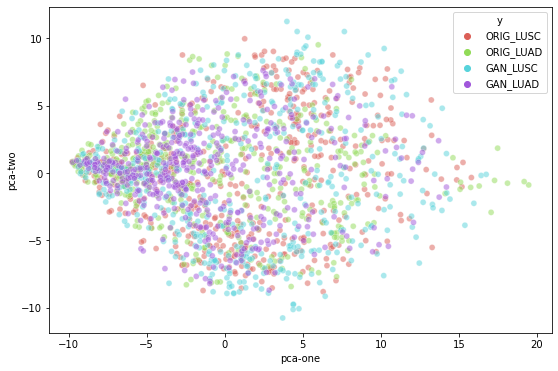

In [94]:
plt.figure(figsize=(9, 6))
sns.scatterplot(
    x="pca-one",
    y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 4),
    data=df,
    legend="full",
    alpha=0.5,
)

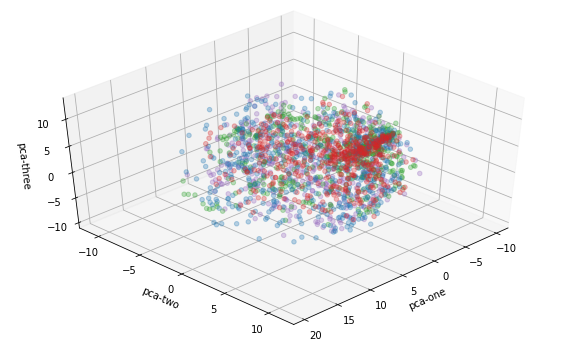

In [95]:
ax = plt.figure(figsize=(10, 6)).gca(projection="3d")
colors = {
    "GAN_LUAD": "tab:red",
    "GAN_LUSC": "tab:blue",
    "ORIG_LUAD": "tab:green",
    "ORIG_LUSC": "tab:purple",
}
ax.scatter(
    xs=df["pca-one"],
    ys=df["pca-two"],
    zs=df["pca-three"],
    c=df["y"].map(colors),
    alpha=0.3,
)
ax.set_xlabel("pca-one")
ax.set_ylabel("pca-two")
ax.set_zlabel("pca-three")
ax.view_init(45, 45)
plt.show()

### T-SNE

In [96]:
data_subset = df[feat_cols].values

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(data_subset)

print("t-SNE done! Time elapsed: {} seconds".format(time.time() - time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.005s...
[t-SNE] Computed neighbors for 2000 samples in 0.175s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 3.286583
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.922752
[t-SNE] KL divergence after 1000 iterations: 1.372819
t-SNE done! Time elapsed: 4.452927112579346 seconds


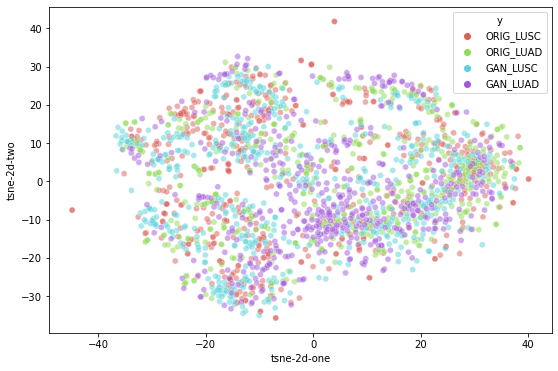

In [97]:
df["tsne-2d-one"] = tsne_results[:, 0]
df["tsne-2d-two"] = tsne_results[:, 1]

plt.figure(figsize=(9, 6))
sns.scatterplot(
    x="tsne-2d-one",
    y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 4),
    data=df,
    legend="full",
    alpha=0.5,
)

In [98]:
time_start = time.time()

tsne = TSNE(n_components=3, verbose=0, perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(data_subset)

print("t-SNE done! Time elapsed: {} seconds".format(time.time() - time_start))

t-SNE done! Time elapsed: 8.044221878051758 seconds


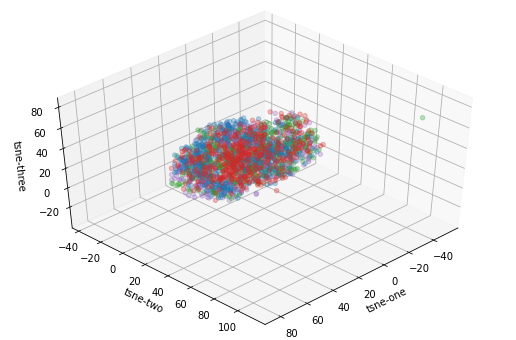

In [99]:
df["tsne-one"] = tsne_results[:, 0]
df["tsne-two"] = tsne_results[:, 1]
df["tsne-three"] = tsne_results[:, 2]
ax = plt.figure(figsize=(9, 6)).gca(projection="3d")
colors = {
    "GAN_LUAD": "tab:red",
    "GAN_LUSC": "tab:blue",
    "ORIG_LUAD": "tab:green",
    "ORIG_LUSC": "tab:purple",
}
ax.scatter(
    xs=df["tsne-one"],
    ys=df["tsne-two"],
    zs=df["tsne-three"],
    c=df["y"].map(colors),
    alpha=0.3,
)
ax.set_xlabel("tsne-one")
ax.set_ylabel("tsne-two")
ax.set_zlabel("tsne-three")
ax.view_init(45, 45)
plt.show()

In [100]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(data_subset)

print(
    f"Cumulative explained variation for 50 principal components: {np.sum(pca_50.explained_variance_ratio_)}"
)

Cumulative explained variation for 50 principal components: 0.7259450646189053


In [101]:
time_start = time.time()

tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000)
tsne_pca_results = tsne.fit_transform(pca_result_50)

print("t-SNE done! Time elapsed: {} seconds".format(time.time() - time_start))

t-SNE done! Time elapsed: 3.9992220401763916 seconds


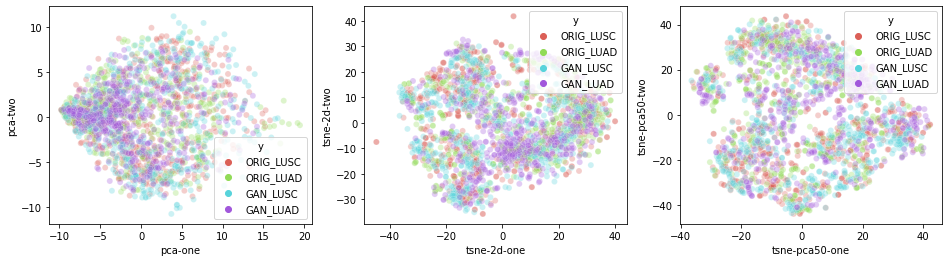

In [102]:
df["tsne-pca50-one"] = tsne_pca_results[:, 0]
df["tsne-pca50-two"] = tsne_pca_results[:, 1]
plt.figure(figsize=(16, 4))
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="pca-one",
    y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 4),
    data=df,
    legend="full",
    alpha=0.3,
    ax=ax1,
)

ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-2d-one",
    y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 4),
    data=df,
    legend="full",
    alpha=0.3,
    ax=ax2,
)

ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-pca50-one",
    y="tsne-pca50-two",
    hue="y",
    palette=sns.color_palette("hls", 4),
    data=df,
    legend="full",
    alpha=0.3,
    ax=ax3,
)

## FID

In [24]:
def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def delete_gan_images():
    directories = [
        "/Storage/PauloOctavioDir/gan_eval/fake_adeno_dicom/",
        "/Storage/PauloOctavioDir/gan_eval/fake_adeno/",
        "/Storage/PauloOctavioDir/gan_eval/fake_squamous_dicom/",
        "/Storage/PauloOctavioDir/gan_eval/fake_squamous/",
    ]

    for directory in directories:
        for file in os.listdir(directory):
            os.remove(os.path.join(directory, file))

In [ ]:
for hist_type in ["adeno", "squamous"]:
    os.makedirs(
        os.path.dirname(f"/Storage/PauloOctavioDir/gan_eval/real_{hist_type}/"),
        exist_ok=True,
    )
    os.makedirs(
        os.path.dirname(f"/Storage/PauloOctavioDir/gan_eval/fake_{hist_type}_dicom/"),
        exist_ok=True,
    )
    os.makedirs(
        os.path.dirname(f"/Storage/PauloOctavioDir/gan_eval/fake_{hist_type}/"),
        exist_ok=True,
    )

In [ ]:
for hist_type in ["adeno", "squamous"]:
    print(hist_type)
    REAL_IMAGES_DIR = f"/Storage/PauloOctavioDir/nodule_rois/gan/{hist_type}/images/"
    for file in os.listdir(REAL_IMAGES_DIR):
        file_path = REAL_IMAGES_DIR + file
        destination = f"/Storage/PauloOctavioDir/gan_eval/real_{hist_type}/"
        dicom_to_png(file_path, destination, 64)
    print(f"    Number of images source: {len(os.listdir(REAL_IMAGES_DIR))}")
    print(f"    Number of images destination: {len(os.listdir(destination))}")

In [17]:
# df = pd.DataFrame(columns=['model', 'fid', 'hist_type','bs'])
# df.to_csv('fid_logging.csv', index=False)

In [25]:
alpha = 1.0
step = 4
LEARNING_RATE = 1e-3
CHANNELS_IMG = 1
Z_DIM = 512
IN_CHANNELS = 512
MIN_HU_VALUE = -1024
MAX_HU_VALUE = 1000
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [26]:
# Final evaluation

df = pd.DataFrame(columns=["model", "fid", "hist_type", "bs"])
df.to_csv("fid_logging.csv", index=False)

seed_everything(42)
for hist_type in ["adeno", "squamous"]:
    REAL_IMAGES_DIR = f"/Storage/PauloOctavioDir/nodule_rois/gan/{hist_type}/images/"
    FAKE_IMAGES_DIR = f"/Storage/PauloOctavioDir/gan_eval/fake_{hist_type}_dicom/"
    BS = 4
    acron = "LUAD" if hist_type == "adeno" else "LUSC"
    gens = [
        f"generator_pggan_roi_{hist_type}_epochs_50_alpha_0.75_aug_rot_blur_sharp.pth.tar",
        f"generator_pggan_roi_{hist_type}_all_data.pth.tar",
        f"generator_pggan_roi_{hist_type}_epochs_75_lr_0.001.pth.tar",
        f"generator_pggan_roi_{hist_type}_epochs_30_30_50_50_75_alpha_0.75_bs_32_32_32_32_32_affn_trns_only.pth.tar",
        #         f'generator_pggan_roi_{hist_type}_epochs_30_30_50_50_75_alpha_0.75_bs_64_64_64_32_32_affn_trns_only.pth.tar',
        f"generator_pggan_roi_{hist_type}_epochs_50_alpha_0.75_bs_64_64_64_32_32_affn_trns_only.pth.tar",
        f"generator_pggan_roi_{hist_type}_epochs_75_alpha_0.75_bs_64_64_64_32_32_affn_trns_only.pth.tar",
        f"generator_pggan_roi_adeno_epochs_30_alpha_0.75_bs_64_64_64_32_32_affn_trns_only.pth.tar",
    ]
    for gen_file in gens:
        print(f"Generator: {gen_file} | Hist type: {hist_type}")
        delete_gan_images()
        gen = Generator(Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG).to(DEVICE)
        opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))
        load_checkpoint(gen_file, gen, opt_gen, LEARNING_RATE)
        gen.train()
        no_images = len(os.listdir(REAL_IMAGES_DIR))
        generate_images(gen, 4, no_images, acron, FAKE_IMAGES_DIR)

        print(f"    Number of generated images: {len(os.listdir(FAKE_IMAGES_DIR))}")

        for file in os.listdir(FAKE_IMAGES_DIR):
            file_path = FAKE_IMAGES_DIR + file
            dicom_to_png(
                file_path, f"/Storage/PauloOctavioDir/gan_eval/fake_{hist_type}/"
            )

        assert len(
            os.listdir(f"/Storage/PauloOctavioDir/gan_eval/fake_{hist_type}/")
        ) == len(
            os.listdir(f"/Storage/PauloOctavioDir/nodule_rois/gan/{hist_type}/images/")
        )

        s = subprocess.getstatusoutput(
            f"""
                python fid.py \
                --path1 /Storage/PauloOctavioDir/gan_eval/real_{hist_type}/ \
                --path2 /Storage/PauloOctavioDir/gan_eval/fake_{hist_type}/ \
                --batch-size {BS}
            """
        )
        fid = s[1].split("\n")[1]
        print(f"FID: {fid}\n")
        df = pd.read_csv("fid_logging.csv")
        try:
            df.loc[len(df)] = [gen_file, float(fid), hist_type, str(BS)]
            df.to_csv("fid_logging.csv", index=False)
        except:
            print(s[1])

df.sort_values(by=["fid", "hist_type"])

Generator: generator_pggan_roi_adeno_epochs_50_alpha_0.75_aug_rot_blur_sharp.pth.tar | Hist type: adeno
=> Loading checkpoint
    Number of generated images: 3263
FID: 40.66285903644484

Generator: generator_pggan_roi_adeno_all_data.pth.tar | Hist type: adeno
=> Loading checkpoint
    Number of generated images: 3263
FID: 48.60506505986177

Generator: generator_pggan_roi_adeno_epochs_75_lr_0.001.pth.tar | Hist type: adeno
=> Loading checkpoint
    Number of generated images: 3263
FID: 36.580051549405766

Generator: generator_pggan_roi_adeno_epochs_30_30_50_50_75_alpha_0.75_bs_32_32_32_32_32_affn_trns_only.pth.tar | Hist type: adeno
=> Loading checkpoint
    Number of generated images: 3263
FID: 31.851769517122506

Generator: generator_pggan_roi_adeno_epochs_50_alpha_0.75_bs_64_64_64_32_32_affn_trns_only.pth.tar | Hist type: adeno
=> Loading checkpoint
    Number of generated images: 3263
FID: 35.04800723065546

Generator: generator_pggan_roi_adeno_epochs_75_alpha_0.75_bs_64_64_64_32_32

,model,fid,hist_type,bs
11,generator_pggan_roi_squamous_epochs_50_alpha_0.75_bs_64_64_64_32_32_affn_trns_only.pth.tar,25.179313,squamous,4
10,generator_pggan_roi_squamous_epochs_30_30_50_50_75_alpha_0.75_bs_32_32_32_32_32_affn_trns_only.p...,29.356332,squamous,4
3,generator_pggan_roi_adeno_epochs_30_30_50_50_75_alpha_0.75_bs_32_32_32_32_32_affn_trns_only.pth.tar,31.851770,adeno,4
8,generator_pggan_roi_squamous_all_data.pth.tar,33.724327,squamous,4
7,generator_pggan_roi_squamous_epochs_50_alpha_0.75_aug_rot_blur_sharp.pth.tar,34.316581,squamous,4
4,generator_pggan_roi_adeno_epochs_50_alpha_0.75_bs_64_64_64_32_32_affn_trns_only.pth.tar,35.048007,adeno,4
13,generator_pggan_roi_adeno_epochs_30_alpha_0.75_bs_64_64_64_32_32_affn_trns_only.pth.tar,35.485587,squamous,4
12,generator_pggan_roi_squamous_epochs_75_alpha_0.75_bs_64_64_64_32_32_affn_trns_only.pth.tar,35.855716,squamous,4
9,generator_pggan_roi_squamous_epochs_75_lr_0.001.pth.tar,36.397891,squamous,4
2,generator_pggan_roi_adeno_epochs_75_lr_0.001.pth.tar,36.580052,adeno,4


In [12]:
# gens = [
#         f'generator_pggan_roi_{hist_type}_epochs_30_alpha_0.75_bs_64_64_64_32_32_affn_trns_only.pth.tar',
#         f'generator_pggan_roi_{hist_type}_epochs_75_alpha_0.75_bs_64_64_64_32_32_affn_trns_only.pth.tar',
#         f'generator_pggan_roi_{hist_type}_epochs_50_alpha_0.75_bs_64_64_64_32_32_affn_trns_only.pth.tar',
#         f'generator_pggan_roi_{hist_type}_epochs_30_30_50_50_75_alpha_0.75_bs_32_32_32_32_32_affn_trns_only.pth.tar',
#         f'generator_pggan_roi_{hist_type}_epochs_30_30_50_50_50_alpha_0.75_bs_32_32_32_32_32_affn_trns_only.pth.tar',
#         f'generator_pggan_roi_{hist_type}_epochs_30_alpha_0.75_bs_32_32_32_32_32_affn_trns_only.pth.tar',
#         f'generator_pggan_roi_{hist_type}_epochs_50_alpha_0.75_bs_32_32_32_32_32_affn_trns_only.pth.tar',
#         f'generator_pggan_roi_{hist_type}_epochs_75_alpha_0.75_bs_32_32_32_32_32_affn_trns_only.pth.tar',
#         f'generator_pggan_roi_{hist_type}_epochs_50_alpha_0.75_aug_rot_blur_sharp.pth.tar',
#         f'generator_pggan_roi_{hist_type}_all_data.pth.tar',
#         f'generator_pggan_roi_{hist_type}_epochs_75_lr_0.001.pth.tar',
#     ]

In [27]:
import pandas as pd

pd.set_option("max_colwidth", 100)

fid_df = pd.read_csv("fid_logging.csv")

gan_df = pd.read_csv("gan_logging.csv").drop_duplicates()
gan_df["model"] = "generator_" + gan_df["model"] + ".pth.tar"

vgg_df = pd.read_csv("vgg16_logging.csv")
gan_test_df = vgg_df[vgg_df["model_name"] == "vgg16_gan_gan_test_s_42"]
gan_test_df = gan_test_df.rename(columns={"avg_acc": "gan_test_acc"})

gan_train_df = vgg_df[vgg_df["model_name"] == "vgg16_gan_gan_train_images_s_42"]
gan_train_df = gan_train_df.rename(columns={"avg_acc": "gan_train_acc"})
gan_train_df_scc = gan_train_df.copy()
gan_train_df_scc["gan_model"] = gan_train_df_scc["gan_model"].str.replace(
    "adeno", "squamous"
)
gan_train_df = gan_train_df.append(gan_train_df_scc)

gan_train_test_df = pd.merge(gan_test_df, gan_train_df, on="gan_model", how="inner")[
    ["gan_model", "gan_test_acc", "gan_train_acc"]
]

vgg_fid_df = pd.merge(
    fid_df, gan_train_test_df, left_on="model", right_on="gan_model", how="left"
)
vgg_fid_df = vgg_fid_df[["model", "fid", "gan_test_acc", "gan_train_acc", "hist_type"]]
vgg_fid_gan_df = pd.merge(
    vgg_fid_df, gan_df, left_on="model", right_on="model", how="left"
)
vgg_fid_gan_df = vgg_fid_gan_df[
    ["model", "fid", "gan_test_acc", "gan_train_acc", "hist_type_x", "epochs", "bs"]
].sort_values(by=["hist_type_x", "model"], ascending=False)
vgg_fid_gan_df.round(3)

,model,fid,gan_test_acc,gan_train_acc,hist_type_x,epochs,bs
9,generator_pggan_roi_squamous_epochs_75_lr_0.001.pth.tar,36.398,0.683,0.491,squamous,NaN,NaN
12,generator_pggan_roi_squamous_epochs_75_alpha_0.75_bs_64_64_64_32_32_affn_trns_only.pth.tar,35.856,0.677,0.527,squamous,NaN,NaN
11,generator_pggan_roi_squamous_epochs_50_alpha_0.75_bs_64_64_64_32_32_affn_trns_only.pth.tar,25.179,0.777,0.609,squamous,NaN,NaN
7,generator_pggan_roi_squamous_epochs_50_alpha_0.75_aug_rot_blur_sharp.pth.tar,34.317,0.616,0.482,squamous,NaN,NaN
10,generator_pggan_roi_squamous_epochs_30_30_50_50_75_alpha_0.75_bs_32_32_32_32_32_affn_trns_only.p...,29.356,0.695,0.618,squamous,30_30_50_50_75,"[32, 32, 32, 32, 32]"
8,generator_pggan_roi_squamous_all_data.pth.tar,33.724,0.756,0.509,squamous,NaN,NaN
13,generator_pggan_roi_adeno_epochs_30_alpha_0.75_bs_64_64_64_32_32_affn_trns_only.pth.tar,35.486,0.528,0.606,squamous,30,"[64, 64, 64, 32, 32]"
2,generator_pggan_roi_adeno_epochs_75_lr_0.001.pth.tar,36.580,0.610,0.491,adeno,NaN,NaN
5,generator_pggan_roi_adeno_epochs_75_alpha_0.75_bs_64_64_64_32_32_affn_trns_only.pth.tar,39.163,0.674,0.527,adeno,75,"[64, 64, 64, 32, 32]"
4,generator_pggan_roi_adeno_epochs_50_alpha_0.75_bs_64_64_64_32_32_affn_trns_only.pth.tar,35.048,0.652,0.609,adeno,50,"[64, 64, 64, 32, 32]"


In [33]:
import pandas as pd

pd.set_option("max_colwidth", 100)

fid_df = pd.read_csv("fid_logging.csv")
vgg_df = pd.read_csv("vgg16_logging.csv")
vgg_df = vgg_df[vgg_df["model_name"] == "vgg16_gan_gan_test_s_42"]
gan_df = pd.read_csv("gan_logging.csv").drop_duplicates()
gan_df["model"] = "generator_" + gan_df["model"] + ".pth.tar"

vgg_fid_df = pd.merge(
    fid_df, vgg_df, left_on="model", right_on="gan_model", how="left"
).reset_index()
vgg_fid_df = vgg_fid_df[["model", "fid", "avg_acc", "hist_type"]]
vgg_fid_gan_df = pd.merge(
    vgg_fid_df, gan_df, left_on="model", right_on="model", how="left"
)
vgg_fid_gan_df[["model", "fid", "avg_acc", "hist_type_x", "epochs", "bs"]].sort_values(
    by=["hist_type_x"], ascending=False
)

,model,fid,avg_acc,hist_type_x,epochs,bs
6,generator_pggan_roi_squamous_epochs_50_alpha_0.75_aug_rot_blur_sharp.pth.tar,34.051399,0.616071,squamous,NaN,NaN
7,generator_pggan_roi_squamous_all_data.pth.tar,33.988068,0.755952,squamous,NaN,NaN
8,generator_pggan_roi_squamous_epochs_75_lr_0.001.pth.tar,36.369539,0.683036,squamous,NaN,NaN
9,generator_pggan_roi_squamous_epochs_30_30_50_50_75_alpha_0.75_bs_32_32_32_32_32_affn_trns_only.p...,29.114810,0.694940,squamous,30_30_50_50_75,"[32, 32, 32, 32, 32]"
10,generator_pggan_roi_squamous_epochs_50_alpha_0.75_bs_64_64_64_32_32_affn_trns_only.pth.tar,25.512527,0.776786,squamous,NaN,NaN
11,generator_pggan_roi_squamous_epochs_75_alpha_0.75_bs_64_64_64_32_32_affn_trns_only.pth.tar,36.437602,0.677083,squamous,NaN,NaN
0,generator_pggan_roi_adeno_epochs_50_alpha_0.75_aug_rot_blur_sharp.pth.tar,40.662859,0.653274,adeno,NaN,NaN
1,generator_pggan_roi_adeno_all_data.pth.tar,48.605065,0.659226,adeno,NaN,NaN
2,generator_pggan_roi_adeno_epochs_75_lr_0.001.pth.tar,36.580052,0.610119,adeno,NaN,NaN
3,generator_pggan_roi_adeno_epochs_30_30_50_50_75_alpha_0.75_bs_32_32_32_32_32_affn_trns_only.pth.tar,31.851770,0.752976,adeno,30_30_50_50_75,"[32, 32, 32, 32, 32]"


In [5]:
pd.read_csv("fid_logging.csv").sort_values(by="fid")

,model,fid,hist_type,bs
1,generator_pggan_roi_adeno_epochs_50_alpha_0.75_bs_32_32_32_32_32_affn_trns_only.pth.tar,34.389766,adeno,4
7,generator_pggan_roi_adeno_epochs_75_lr_0.001.pth.tar,37.007032,adeno,4
3,generator_pggan_roi_adeno_epochs_30_alpha_0.75_bs_64_64_64_32_32_affn_trns_only.pth.tar,39.427187,adeno,4
0,generator_pggan_roi_adeno_epochs_30_alpha_0.75_bs_32_32_32_32_32_affn_trns_only.pth.tar,39.856332,adeno,4
2,generator_pggan_roi_adeno_epochs_75_alpha_0.75_bs_32_32_32_32_32_affn_trns_only.pth.tar,40.242736,adeno,4
5,generator_pggan_roi_adeno_epochs_50_alpha_0.75_aug_rot_blur_sharp.pth.tar,40.789604,adeno,4
6,generator_pggan_roi_adeno_all_data.pth.tar,48.423194,adeno,4
4,generator_pggan_roi_adeno_epochs_75_alpha_0.75_bs_64_64_64_32_32_affn_trns_only.pth.tar,212.978431,adeno,4


In [33]:
def generate_black_png_img(output_file):
    img = np.zeros((64, 64))
    img = Image.fromarray(img)
    img = np.uint8(img)
    with open(output_file, "wb") as png_file:
        w = png.Writer(64, 64, greyscale=True)
        w.write(png_file, img)

In [34]:
black_path = "/Storage/PauloOctavioDir/gan_eval/bench_images/"
hist_type = "adeno"
REAL_IMAGES_DIR = f"/Storage/PauloOctavioDir/gan_eval/real_{hist_type}/"
seed_everything(42)
for i, _ in enumerate(os.listdir()):
    file_name = f"{str(i).zfill(4)}.png"
    generate_black_png_img(black_path + file_name)

s = subprocess.getstatusoutput(
    f"""
    python fid.py --path1 /Storage/PauloOctavioDir/gan_eval/real_{hist_type}/ --path2 /Storage/PauloOctavioDir/gan_eval/bench_images/ --batch-size 4"""
)
fid = s[1].split("\n")[1]
print(f"FID: {fid}\n")
df = pd.read_csv("fid_logging.csv")
df.loc[len(df)] = ["all_black_images", float(fid), None]
df.to_csv("fid_logging.csv", index=False)

FID: 330.626222310696



In [23]:
ORIG_ADENO_PATH = "/Storage/PauloOctavioDir/nodule_rois/gan/adeno/images/"
ORIG_ADENO_AUG_PATH = "/Storage/PauloOctavioDir/nodule_rois/gan_aug/adeno/images/"

orig_adeno_images = np.concatenate(
    [
        get_windowed_hu(ORIG_ADENO_PATH + file).flatten()
        for file in os.listdir(ORIG_ADENO_PATH)
    ]
)
gan_squamous_images = np.concatenate(
    [
        get_windowed_hu(ORIG_ADENO_AUG_PATH + file).flatten()
        for file in os.listdir(ORIG_ADENO_AUG_PATH)
        if "AUG" in file
    ]
)

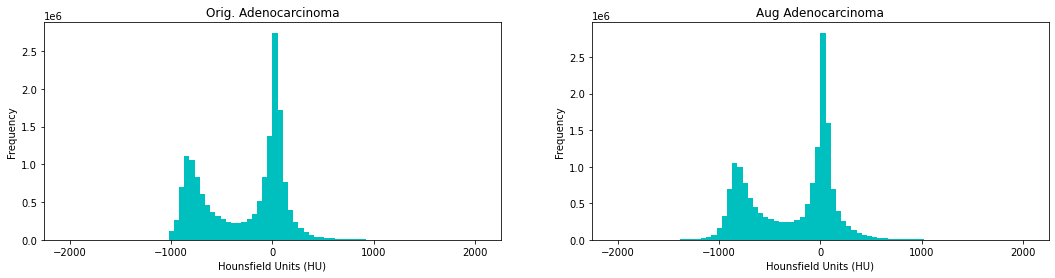

In [8]:
images = [orig_adeno_images, gan_squamous_images]
titles = ["Orig. Adenocarcinoma", "Aug Adenocarcinoma"]
fig, axes = plt.subplots(1, 2, figsize=(18, 4))
for i, (data, title) in enumerate(zip(images, titles)):
    axes[i].hist(data, bins=80, color="c", range=(-2048, 2048))
    axes[i].set_xlabel("Hounsfield Units (HU)")
    axes[i].set_ylabel("Frequency")
    axes[i].set_title(title)
plt.show()